In [1]:
# Summer 2021 Internship project with Oak Ride National Laboratory (ORNL)
# Code Written By: Arjun Viswanathan
# Mentored By: Dr. Junqi Yin
# Date Started: 6/7/2021
# Date TBC: 8/13/2021
# All datasets provided by Dr. Yin

import h5py
import numpy as np
from matplotlib import pyplot as plt
import time
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model

In [2]:
print(str(time.ctime()) + ": Initializing...")
sarsmerscov_train = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_train.h5', 'r')
sarsmerscov_val = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_val.h5', 'r')
lt = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_train.txt', 'r'))
lv = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_val.txt', 'r')) # open all files

label_training = np.array([])
label_validation = np.array([])

train_size = 60000 # 10% of the datasets
val_size = 15000

for i in range(train_size):
    num = int(str(lt[i]).strip('\n'))
    label_training = np.append(label_training, num)
    
for j in range(val_size):
    num = int(str(lv[j]).strip('\n'))
    label_validation = np.append(label_validation, num)

lt_onehot = to_categorical(label_training) # make one hot vectors
lv_onehot = to_categorical(label_validation)

trainset = np.array(sarsmerscov_train['contact_maps'][0:train_size]).astype(float) # 60000 x 24 x 24 x 1
valset = np.array(sarsmerscov_val['contact_maps'][0:val_size]).astype(float) # 15000 x 24 x 24 x 1
train_3D = np.tril(trainset[:, :, :, 0])
val_3D = np.tril(valset[:, :, :, 0])

lt = None
lv = None
sarsmerscov_train = None
sarsmerscov_val = None # garbage collection to free up memory

print(str(time.ctime()) + ": Successfully loaded all data sets!")

Wed Jun 16 11:21:32 2021: Initializing...
Wed Jun 16 11:21:33 2021: Successfully loaded all data sets!


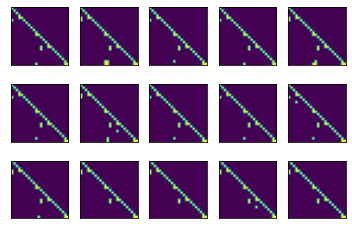

In [3]:
plt.figure(1)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_3D[i, :, :])
plt.show()

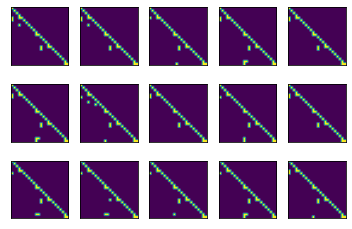

In [4]:
plt.figure(2)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_3D[i, :, :])
plt.show()

In [5]:
print(str(time.ctime()) + ": Implementing PCA Clustering...")

train_pca = np.reshape(train_3D, (train_3D.shape[0], -1))  # 60000 x 576
val_pca = np.reshape(val_3D, (val_3D.shape[0], -1))  # 15000 x 576

normalized_train_pca = normalize(train_pca, axis=1, norm='l1')
normalized_val_pca = normalize(val_pca, axis=1, norm='l1')

pca = PCA(2)  # 2 PCs
pca.fit(normalized_train_pca)
reduced_train = pca.transform(normalized_train_pca)
reduced_val = pca.transform(normalized_val_pca) # reduce dimensions of both sets

print('Total explained variance: {}'.format(pca.explained_variance_ratio_.sum() * 100))

print(str(time.ctime()) + ": Finished PCA Clustering!")

Wed Jun 16 11:21:34 2021: Implementing PCA Clustering...
Total explained variance: 49.78138346235982
Wed Jun 16 11:21:36 2021: Finished PCA Clustering!


In [6]:
print(str(time.ctime()) + ": Implementing PCA ML...")

batch_size = 100
epochs = 10

pcamodel = Sequential()
pcamodel.add(Dense(1024, activation='relu', input_shape=(2,)))
pcamodel.add(Dense(512, activation='relu'))
pcamodel.add(Dense(256, activation='relu'))
pcamodel.add(Dense(128, activation='relu'))
pcamodel.add(Dense(3, activation='softmax'))

pcamodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history = pcamodel.fit(reduced_train, lt_onehot, batch_size=batch_size, epochs=epochs, validation_data=(reduced_val, lv_onehot))

print(str(time.ctime()) + ": Finished PCA ML")

Wed Jun 16 11:21:36 2021: Implementing PCA ML...
Epoch 1/10
600/600 [==============================] - 2s 2ms/step - loss: 0.6172 - categorical_accuracy: 0.6459 - val_loss: 0.5040 - val_categorical_accuracy: 0.7003
Epoch 2/10
600/600 [==============================] - 1s 1ms/step - loss: 0.5102 - categorical_accuracy: 0.6935 - val_loss: 0.4829 - val_categorical_accuracy: 0.7017
Epoch 3/10
600/600 [==============================] - 1s 1ms/step - loss: 0.4933 - categorical_accuracy: 0.6967 - val_loss: 0.4779 - val_categorical_accuracy: 0.7022
Epoch 4/10
600/600 [==============================] - 1s 1ms/step - loss: 0.4824 - categorical_accuracy: 0.7031 - val_loss: 0.4684 - val_categorical_accuracy: 0.7089
Epoch 5/10
600/600 [==============================] - 1s 1ms/step - loss: 0.4737 - categorical_accuracy: 0.7096 - val_loss: 0.4704 - val_categorical_accuracy: 0.7076
Epoch 6/10
600/600 [==============================] - 1s 1ms/step - loss: 0.4739 - categorical_accuracy: 0.7051 - val_los

In [7]:
print(str(time.ctime()) + ": Predicting with PCA Model...")

result = pcamodel.predict(reduced_val)
result = np.argmax(np.round(result), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Wed Jun 16 11:21:45 2021: Predicting with PCA Model...
Wed Jun 16 11:21:45 2021: Finished predictions!


In [8]:
correct = np.where(result == label_validation)[0]
incorrect = np.where(result != label_validation)[0]
print("Number of Correct Classifications: {}".format(len(correct)))
print("Number of Incorrect Classifications: {}".format(len(incorrect)))
print("Total Accuracy: {}".format((len(correct) / len(label_validation)) * 100))

Number of Correct Classifications: 10690
Number of Incorrect Classifications: 4310
Total Accuracy: 71.26666666666667


In [9]:
print(str(time.ctime()) + ": Implementing K-Means Clustering...")
km = KMeans(n_clusters=3, random_state=0)
km.fit(train_pca)
labels_val = np.array(km.predict(val_pca))

accuracy = (sum(labels_val == label_validation) / len(label_validation)) * 100

print('Accuracy: {}'.format(accuracy))
print(str(time.ctime()) + ": Finished K-Means Clustering!")

Wed Jun 16 11:21:45 2021: Implementing K-Means Clustering...
Accuracy: 65.90666666666667
Wed Jun 16 11:21:48 2021: Finished K-Means Clustering!


In [10]:
train_X, valid_X, train_label, valid_label = train_test_split(trainset, lt_onehot, test_size=0.2, random_state=0)
# train_X = 492965 x 24 x 24 x 1
# valid_X = 123242 x 24 x 24 x 1
# train_label = 492965 x 3
# valid_label = 123242 x 3

In [11]:
print(str(time.ctime()) + ": Creating Classification Model...")

x = Input(shape=(24, 24, 1))  # 24 x 24 x 1

e_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # 24 x 24 x 32
pool1 = MaxPool2D((2, 2), padding='same')(e_conv1) # 12 x 12 x 32
b_norm1 = BatchNormalization()(pool1)

e_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm1) # 12 x 12 x 64
pool2 = MaxPool2D((2, 2), padding='same')(e_conv2) # 6 x 6 x 64
b_norm2 = BatchNormalization()(pool2)

e_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm2) # 6 x 6 x 128
pool3 = MaxPool2D((2, 2), padding='same')(e_conv3) # 3 x 3 x 128
b_norm3 = BatchNormalization()(pool3)

d_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm3) # 3 x 3 x 128
up1 = UpSampling2D((2, 2))(d_conv1) # 6 x 6 x 128
b_norm4 = BatchNormalization()(up1)

d_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm4) # 6 x 6 x 64
up2 = UpSampling2D((2, 2))(d_conv2) # 12 x 12 x 64
b_norm5 = BatchNormalization()(up2)

d_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(b_norm5) # 12 x 12 x 32
up3 = UpSampling2D((2, 2))(d_conv3) # 24 x 24 x 64
b_norm6 = BatchNormalization()(up3)

d_conv4 = Conv2D(1, (1, 1), activation='relu', padding='same')(b_norm6) # 24 x 24 x 1
b_norm7 = BatchNormalization()(d_conv4)

f1 = Flatten()(b_norm7) # add a fully connected layer after just the autoencoder. 576 x 1
dense = Dense(128, activation='relu')(f1) # 128 x 1
r = Dense(3, activation='softmax')(dense) # 3 x 1

classification_model = Model(x, r) # compile full model
classification_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['categorical_accuracy'])

print(str(time.ctime()) + ": Successfully created Classification Model")

Wed Jun 16 11:21:48 2021: Creating Classification Model...
Wed Jun 16 11:21:48 2021: Successfully created Classification Model


In [12]:
print(str(time.ctime()) + ": Training Classification Model...")

epochs = 10
batch_size = 100
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
classify_labels = classification_model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs, callbacks=[early_stop])

print(str(time.ctime()) + ": Finished training!")

Wed Jun 16 11:21:48 2021: Training Classification Model...
Epoch 1/10
480/480 [==============================] - 4s 4ms/step - loss: 0.4927 - categorical_accuracy: 0.7088
Epoch 2/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4298 - categorical_accuracy: 0.7346
Epoch 3/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4305 - categorical_accuracy: 0.7333
Epoch 4/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4274 - categorical_accuracy: 0.7387
Epoch 5/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4246 - categorical_accuracy: 0.7418
Epoch 6/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4266 - categorical_accuracy: 0.7370
Epoch 7/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4260 - categorical_accuracy: 0.7401
Epoch 8/10
480/480 [==============================] - 2s 4ms/step - loss: 0.4232 - categorical_accuracy: 0.7431
Epoch 9/10
480/480 [=========================

In [13]:
print(str(time.ctime()) + ": Evaluating Classification Model...")

test_eval = classification_model.evaluate(valid_X, valid_label)
print('Loss: {}'.format(test_eval[0]))
print('Accuracy: {}'.format(test_eval[1] * 100))

print(str(time.ctime()) + ": Finished evaluation!")

Wed Jun 16 11:22:10 2021: Evaluating Classification Model...
375/375 [==============================] - 1s 2ms/step - loss: 0.4299 - categorical_accuracy: 0.7447
Loss: 0.42991703748703003
Accuracy: 74.46666955947876
Wed Jun 16 11:22:10 2021: Finished evaluation!


In [14]:
print(str(time.ctime()) + ": Predicting with Classification Model...")

predicted = classification_model.predict(valset)
predicted = np.argmax(np.round(predicted), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Wed Jun 16 11:22:10 2021: Predicting with Classification Model...
Wed Jun 16 11:22:11 2021: Finished predictions!


In [15]:
correct = np.where(predicted == label_validation)[0]
incorrect = np.where(predicted != label_validation)[0]
print("Number of Correct Classifications: " + str(len(correct)))
print("Number of Incorrect Classifications: " + str(len(incorrect)))

Number of Correct Classifications: 11067
Number of Incorrect Classifications: 3933


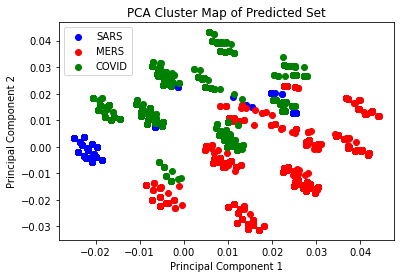

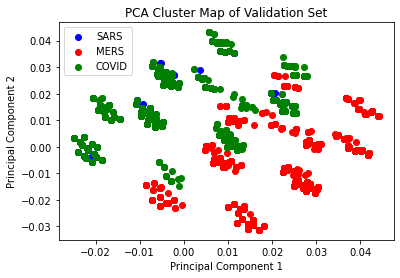

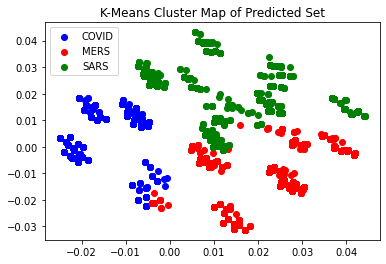

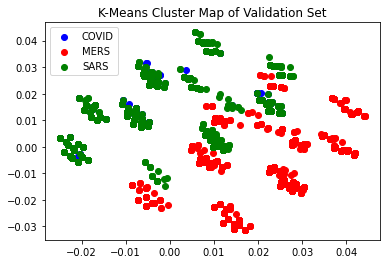

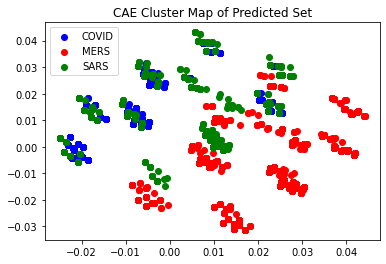

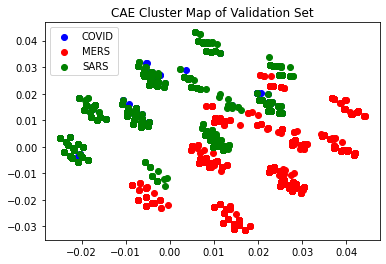

In [16]:
plt.figure(3)
plt.scatter(reduced_val[result == 0, 0], reduced_val[result == 0, 1], c='b', label='SARS', alpha=1)
plt.scatter(reduced_val[result == 1, 0], reduced_val[result == 1, 1], c='r', label='MERS', alpha=1)
plt.scatter(reduced_val[result == 2, 0], reduced_val[result == 2, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Predicted Set')

plt.figure(4)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='SARS', alpha=1)
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS', alpha=1)
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Validation Set')

plt.figure(5)
plt.scatter(reduced_val[labels_val == 0, 0], reduced_val[labels_val == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[labels_val == 1, 0], reduced_val[labels_val == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[labels_val == 2, 0], reduced_val[labels_val == 2, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Predicted Set')
plt.legend(loc='upper left')

plt.figure(6)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Validation Set')
plt.legend(loc='upper left')

plt.figure(7)
plt.scatter(reduced_val[predicted == 0, 0], reduced_val[predicted == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[predicted == 1, 0], reduced_val[predicted == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[predicted == 2, 0], reduced_val[predicted == 2, 1], c='g', label='SARS')
plt.title('CAE Cluster Map of Predicted Set')
plt.legend(loc='upper left')

plt.figure(8)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='SARS')
plt.title('CAE Cluster Map of Validation Set')
plt.legend(loc='upper left')

plt.show()